## Carga y Slicing de Datos

In [2]:
import numpy as np 
import seaborn as sns
import sklearn as skl
from matplotlib import pyplot as plt 

# Utiliza el estilo de gráficos de Seaborn incluso cuando se utiliza Matplotlib
sns.set()

# Se cargan los datos sobre predicción de precios de casas
Data = np.load('proyecto_training_data.npy')

# Dimensiones de los datos
filas, cols = Data.shape

# Límite para extraer los datos de entrenamiento (80%)
lim_sup_train = int(filas*0.8)

# Extracción de datos de entrenamiento (80%) y de validación (20%)
train_data = Data[0:lim_sup_train, :]
test_data = Data[lim_sup_train:filas, :]


## Análisis Exploratorio de los Datos

Cálculo de la media, valor máximo, valor mínimo, rango y desviación estándar de tanto X como Y.

In [64]:
# Medias para cada variable en el dataset 
# (nanmean ignora valores NaN)
medias = np.nanmean(Data, axis=0)

# Valor máximo y mínimo de cada variable
val_max = np.nanmax(Data, axis=0)
val_min = np.nanmin(Data, axis=0)

# Rango "pico a pico" de cada variable
rango = val_max - val_min

# Desviación estándar de cada variable
desvest = np.nanstd(Data, axis=0)

# Utilizado para evitar que Numpy utilice notación científica
np.set_printoptions(precision=3, suppress=True)

print("Medias:", np.around(medias, decimals=2))
print("Max:", val_max)
print("Min:", val_min)
print("Rango:", rango)
print("Desviación Est:", desvest)

Medias: [180921.2       6.1    1162.63      6.52   1971.27     70.05]
Max: [755000.     10.   4692.     14.   2010.    313.]
Min: [34900.     1.   334.     2.  1872.    21.]
Rango: [720100.      9.   4358.     12.    138.    292.]
Desviación Est: [79415.292     1.383   386.455     1.625    30.193    24.275]


Para cada variable en el dataset usar seaborn para graficar un histograma de la variable.

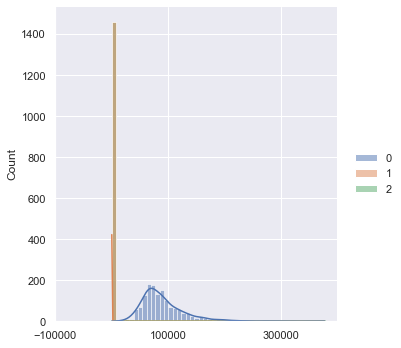

In [27]:
sns.set_theme()
plot_filas = 2
plot_cols = 3

# Subplot con el número de columnas y filas específicado
#fig, axes = plt.subplots(plot_filas, plot_cols)

g = sns.displot(data=Data[:,[0,2,4]], kde=True)
g.set_xticklabels(step=2)

#g = sns.displot(data=Data, x=Data[:,2], kde=True)

#g = sns.displot(data=Data, x=Data[:,4], kde=True)

## Correlación y Gráfica de X y Y

Gráfica de los puntos X y Y utilizando un scatter plot, además de la presentación del coeficiente de correlación entre ambas variables

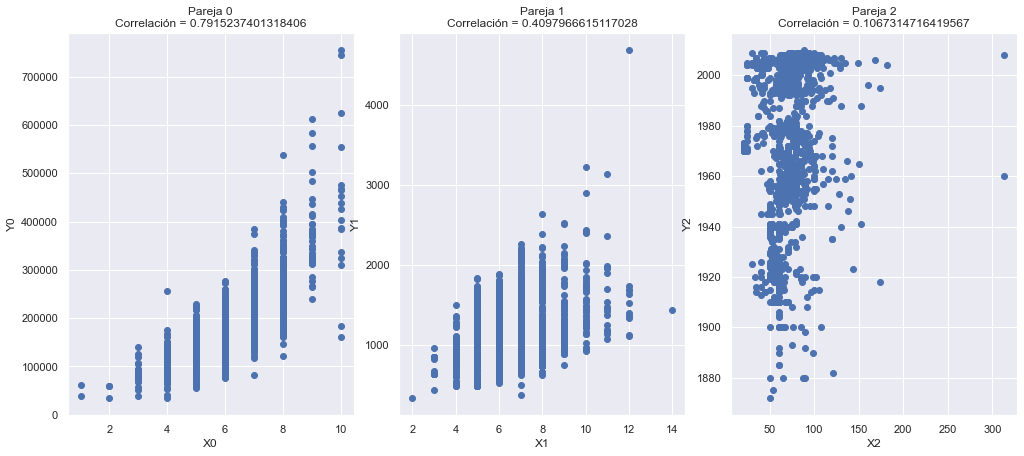

In [59]:
# Correlación de Pearson
def corr_pearson(X,Y):

    # Media de X y Y (Cada serie de valores es una columna nueva)
    MediaX = np.nanmean(X, axis=0)
    MediaY = np.nanmean(Y, axis=0)

    # Cálculo de la covarianza
    Numerador = np.nansum((X - MediaX)*(Y - MediaY), axis=0)
    Covarianza = Numerador / (X.shape[0] - 1)

    return Covarianza / (np.nanstd(X, axis=0) * np.nanstd(Y, axis=0))

X = Data[:,(1,3,5)]
Y = Data[:,(0,2,4)]
Correlacion = corr_pearson(X,Y)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(14,6)
fig.tight_layout()

for i in range(3):
    axes[i].scatter(X[:,i], Y[:,i])
    axes[i].set_xlabel(f"X{i}")
    axes[i].set_ylabel(f"Y{i}")
    axes[i].title.set_text(f"Pareja {i}\nCorrelación = {Correlacion[i]}")


De acuerdo con lo observado en la gráfica y los coeficientes de correlación obtenidos, se podría llegar a establecer que la pareja que presenta mayor "potencial predictivo" utilizando un modelo lineal es la pareja 0 o aquella que corresponde a las primeras dos columnas de los datos cargados. 

## Función para Modelo de Regresión Lineal

Función para entrenar un modelo de regresión lineal de una variable con la forma y = mx + b

In [108]:
def train_linreg(X, Y, epochs=1000, imprimir_error_cada=10, lr=0.0001):

    # Se redimensionan los arrays para convertirlos en vectores columna
    X = np.reshape(X, (len(X), 1))
    Y = np.reshape(Y, (len(Y), 1))

    # Se le agrega una columna de unos
    X = np.append(X, np.ones(X.shape), axis=1)

    # Se inicializan los parámetros "m" y "b"
    # Se crea un vector fila para los parametros (Vector de 2X1)
    m = 0
    b = 0
    params = np.array([m, b])
    params = np.reshape(params, (len(params), 1))

    # Se almacena el primer modelo en un diccionario
    modelo = {}
    modelo[0] = params

    # Historial del error obtenido por epoch
    error_historial = np.zeros((epochs,1))

    # Código para las epochs
    for i in range(epochs):

        # Cálculo de yhat o la estimación de los valores de y
        yhat = np.dot(X, params)

        # Cálculo del error entre "y" y "yhat"
        error = np.mean((Y - yhat)**2) / 2

        # Se guarda el error actual en el historial
        error_historial[i] = error

        # Cálculo del gradiente del error con respecto a cada parámetro
        #   Elemento 0: Gradiente de m
        #   Elemento 1: Gradiente de b
        grad = np.mean((yhat - Y) * X, axis=0)
        grad = np.reshape(grad, (len(grad), 1))

        # Actualización de los parámetros del modelo
        params = params - lr * grad

        # Almacenamiento del modelo en la iteración actual en un diccionario
        modelo[i+1] = params


    return modelo, error_historial


Función que permita visualizar como cambia el error en el tiempo. Esta debe tomar como parámetro el vector de errores generados durante el entrenamiento y graficar en el eje "X" el número de iteración y en el eje "Y" el error para esa iteración

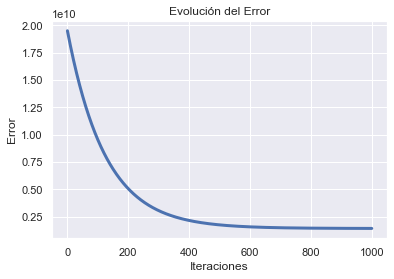

In [111]:
def visualizar_error(error):
    
    # Vector con el número de iteraciones (array que incrementa de 1 en 1)
    Iteraciones = np.arange(1, len(error)+1, 1)
    
    # Se grafica el desarrollo del error
    plt.plot(Iteraciones, error, linewidth=3)
    plt.xlabel("Iteraciones")
    plt.ylabel("Error")
    plt.title("Evolución del Error")

    return None


X = Data[:,1]
Y = Data[:,0]

modelo, error = train_linreg(X,Y)
visualizar_error(error)
